In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl
import os

import sys
from tqdm import tqdm
from astropy.io import fits
import scipy
sys.path.append('../../../wdtools/')
import wdtools
sys.path.append('../../../')
import WD_models
from bisect import bisect_left
import lmfit
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458


na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52

ca2k = 3934.777

ch = 4302

plt.rcParams.update({'font.size': 18})
#%matplotlib inline
from matplotlib.colors import LogNorm

lamgrid = np.linspace(3700, 9500, (9500-3700)*5)
loglamgrid = np.log(lamgrid)

Bad val "'w'" on line #28
	"figure.facecolor : 'w'
"
	in file "/Users/vedantchandra/.matplotlib/stylelib/vedant.mplstyle"
	Key figure.facecolor: 'w' does not look like a color arg
Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWa

## Interpolate PHOENIX Models

## Fit Fe/H

In [2]:
import lmfit

sp = wdtools.SpecTools()

table = Table.read('tables/ew_table.fits')

interp_phx = pickle.load(open('interp/interp_phx.p', 'rb'))

def load_model(teff, logg, feh, wl, res):
    fl = 10**interp_phx((logg, np.log10(teff), feh, np.log(wl)))
    delta = np.median(np.diff(wl))
    sigma = res / delta
    
    fl = scipy.ndimage.gaussian_filter1d(fl, sigma)
    
    return fl

def rv_corr(wl, fl):
    obs_alpha,_,_, _, _ = sp.find_centroid(wl, fl, halpha, make_plot = False, n_fit = 2, 
                            half_window = 50, debug = False, window_step = 5)

    vr = - 1e-3 * speed_light * (obs_alpha - halpha)/halpha

    fl, shift_wl = pyasl.dopplerShift(wl, fl, vr, edgeHandling = 'fillValue', fillValue = 1)
    return wl, fl

def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

def norm_balmer(wl, fl):
    alphawl, alphafl = cont_norm(wl, fl, halpha, 60, 15)
    betawl, betafl = cont_norm(wl, fl, hbeta, 60, 15)
    gammawl, gammafl = cont_norm(wl, fl, hgamma, 60, 15)
    deltawl,deltafl = cont_norm(wl, fl, hdelta, 60, 15)
    epswl,epsfl = cont_norm(wl, fl, 3970, 30, 10)
    zetwl,zetfl = cont_norm(wl, fl, 3889, 30, 10)
    
    wl = np.concatenate((zetwl, epswl, deltawl, gammawl, betawl, alphawl))
    fl = np.concatenate((zetfl, epsfl, deltafl, gammafl, betafl, alphafl))
    
    return wl, fl

def norm_feh(wl, fl):
    ca2kwl, ca2kfl = cont_norm(wl, fl, ca2k, 25, 5)
    
    wl = ca2kwl
    fl = ca2kfl
    
    return wl, fl

In [3]:
plt.plot(*norm_balmer(wl, fl))

NameError: name 'wl' is not defined

In [4]:
sys.path.append('/Users/vedantchandra/isochrones/')
from isochrones import get_ichrone

Holoviews not imported. Some visualizations will not be available.


In [5]:
tracks = get_ichrone('mist', tracks = 'True', bands = ['SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z'])

In [6]:
tracks.generate(0.6, 9.5, -3.9, distance = 1000)

,delta_nu,phase,radius,Mbol,logL,mass,nu_max,feh,density,logg,...,dt_deep,SDSS_u_mag,SDSS_g_mag,SDSS_r_mag,SDSS_i_mag,SDSS_z_mag,distance,AV,initial_feh,requested_age
0,302.710863,0.0,0.507788,6.536022,-0.718409,0.59998,7491.091771,-3.903912,6.460261,4.80492,...,0.016717,17.996344,17.101911,16.603177,16.409081,16.322637,1000.0,0.0,-3.9,9.5


In [7]:
def get_mist_ugriz(mass, age, feh, plx):
    ichrone = tracks.generate(mass, age, feh, distance = 1000 / plx)
    model_sed = np.array(ichrone[['SDSS_u_mag', 'SDSS_g_mag', 
                                                          'SDSS_r_mag', 'SDSS_i_mag', 'SDSS_z_mag']])[0]    
    return model_sed

In [8]:
L = 1350 #pc, ABL+16

def log_exp_dec_prior(parallax):
    r = 1000 / parallax #pc
    prior = (1 / (2 * L**3)) * (r**2) * np.exp(-r / L)
    if prior <= 0:
        return -np.Inf
    return np.log(prior)

import emcee
import corner

In [9]:
#def fit_sed(sed, e_sed, parallax, parallax_error):
 
    
def get_mist_map(obj):
    
    sed = np.array([obj['u'], obj['g'], obj['r'], obj['i'], obj['z']])
    e_sed = np.array([obj['su'], obj['sg'], obj['sr'], obj['si'], obj['sz']])
    e_sed[e_sed < 0.03] = 0.03

    parallax, parallax_error = obj['parallax'], obj['parallax_error'] 

    plx_norm = stats.norm(loc = parallax, scale = parallax_error)

    def logprior(params):
        mass, age, feh, plx = params

        if plx <= 0:
            return -np.Inf

        if mass < 0.1 or mass > 1.5:
            return -np.Inf

        if age < 1 or age > 10.3:
            return -np.Inf

        if feh < -4 or feh > 0:
            return -np.Inf

        return log_exp_dec_prior(plx) + plx_norm.logpdf(plx)

    def loglik(params):
        mass, age, feh, plx = params

        model_sed = get_mist_ugriz(mass, age, feh, plx)

        resid = sed - model_sed

    #     plt.plot(sed)
    #     plt.plot(model_sed)

        chi2 = np.sum(resid**2 / e_sed**2)

        if np.isnan(chi2):
            return -np.Inf

        return - 0.5 * chi2

    def logprob(params):

        prior = logprior(params)

        if not np.isfinite(prior):
            return -np.Inf
        if np.isnan(prior):
            return -np.Inf
        else:
            return prior + loglik(params)
        
    nll = lambda *args: -logprob(*args)
    init = (0.5, 9, -2, parallax)
    soln = scipy.optimize.minimize(nll, init, method = 'Nelder-Mead')

#     ndim,nwalkers = 4, 15
#     p0 = np.zeros((nwalkers, ndim))

#     lims = [[0.1, 1.5], [8, 10], [-4, 0], [parallax, parallax + parallax_error]]

#     for jj in range(ndim):
#         if jj != 3:
#             p0[:, jj] = np.random.uniform(lims[jj][0], lims[jj][1], size = nwalkers)
#         elif jj == 3:
#             p0[:, jj] = parallax + parallax_error * np.random.normal(size = nwalkers)
#             p0[:, jj][p0[:, jj] < 0] = 1e-5

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob)

#     b0 = sampler.run_mcmc(p0, 10, progress = False);
#     sampler.reset()
#     b1 = sampler.run_mcmc(b0, 10, progress = False)

#     lp = sampler.get_log_prob(flat = True)
#     map_sample = sampler.flatchain[np.argmax(lp)]
    #map_sample = np.median(sampler.flatchain, axis = 0)
    
    return soln.x

In [10]:
ii = 25
flt = get_mist_map(table[ii])
print(table[ii]['parallax'], table[ii]['parallax_error'])

0.44201773806684763 0.14589276271180832


In [11]:
flt

array([ 0.74624481,  9.85194339, -1.30488287,  0.45014628])

In [12]:
def get_mist_params(obj):
    res = get_mist_map(obj)
    ichrone = tracks.generate(res[0], res[1], res[2], distance = 1000 / res[3])
    return 10**ichrone['logTeff'][0], ichrone['logg'][0], res[2], res

In [13]:
get_mist_params(table[57])

(6479.913458059192,
 4.232247286035438,
 -0.3134014032278809,
 array([ 1.15346153,  7.18033286, -0.3134014 ,  0.16034663]))

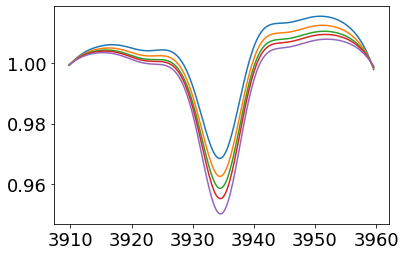

In [14]:
feh = -3.923
teff = 6024

mfl = load_model(teff, 3.5, feh, lamgrid, 3)
mwl, mfl = cont_norm(lamgrid, mfl, ca2k, window = 25, edge = 5)
plt.plot(mwl, mfl)

mfl = load_model(teff, 3.8, feh, lamgrid, 3)
mwl, mfl = cont_norm(lamgrid, mfl, ca2k, window = 25, edge = 5)
plt.plot(mwl, mfl)

mfl = load_model(teff, 4, feh, lamgrid, 3)
mwl, mfl = cont_norm(lamgrid, mfl, ca2k, window = 25, edge = 5)
plt.plot(mwl, mfl)

mfl = load_model(teff, 4.2, feh, lamgrid, 3)
mwl, mfl = cont_norm(lamgrid, mfl, ca2k, window = 25, edge = 5)
plt.plot(mwl, mfl)

mfl = load_model(teff, 4.5, feh, lamgrid, 3)
mwl, mfl = cont_norm(lamgrid, mfl, ca2k, window = 25, edge = 5)
plt.plot(mwl, mfl)

In [39]:
def get_spectrum(source_id):
    path = '../../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

def get_res(wl, sky):
    gauss = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()
    params = gauss.make_params()
    skyline = 6301
    params['center'].set(value = skyline, min = skyline-15, max = skyline +15, vary = True)
    params['amplitude'].set(min = 0, value = 50)
    params['c'].set(value = 1)
    
    c1 = bisect_left(wl, skyline-50)
    c2 = bisect_left(wl, skyline+50)
    wl = wl[c1:c2]
    sky = sky[c1:c2]
    norm_idx = bisect_left(wl, skyline - 15)
    sky = sky / sky[norm_idx]
    
    try:
        result = gauss.fit(sky, params, x = wl, method = 'Nelder-Mead')
        data_res = result.params['sigma'].value
    except:
        print('sky fit failed. defaulting to 1.5')
        data_res = 1.5
    
#     plt.plot(wl,sky)
#     plt.plot(wl, gauss.eval(result.params, x = wl))
    
    return data_res

def balmer_resid(params, wl, bfl, spec_res, plot = False):

    model_spec = load_model(params['teff'], params['logg'], params['feh'], wl = wl, res = spec_res)

    mwl, mfl = norm_balmer(wl, model_spec)

    resid = mfl - bfl

    if plot:
        breakpoints = np.nonzero(np.diff(wl) > 5)[0]
        breakpoints = np.concatenate(([0], breakpoints, [None]))
        plt.figure(figsize = (5,8))
        for kk in range(len(breakpoints) - 1):
            wl_seg = wl[breakpoints[kk] + 1:breakpoints[kk+1]]
            fl_seg = bfl[breakpoints[kk] + 1:breakpoints[kk+1]]
            model_seg = mfl[breakpoints[kk] + 1:breakpoints[kk+1]]
            peak = int(len(wl_seg)/2)
            delta_wl = wl_seg - wl_seg[peak]
            plt.plot(delta_wl, 1 + fl_seg - 0.45 * kk, 'k')
            plt.plot(delta_wl, 1 + model_seg - 0.45 * kk, 'r')

        plt.xlabel(r'$\mathrm{\Delta \lambda}\ (\mathrm{\AA})$')
        plt.ylabel('Normalized Flux')
        plt.show()

    return resid

# model = lmfit.models.ConstantModel() - lmfit.models.PseudoVoigtModel()
# params = model.make_params()
# params['c'].set(value = 1, vary = False)
# params['amplitude'].set(value = 0.5, min = 0)
# params['sigma'].set(value = 1, min = 0)


def get_ew(wl, fl, centre, window, edge, plot = False):
    
    wl, fl = cont_norm(wl, fl, centre, window, edge)
    
#     params = model.make_params()
#     params['c'].set(value = 1, vary = False)
#     params['center'].set(value = centre, min = centre - 5, max = centre + 5)
#     params['amplitude'].set(value = 1, min = 0)
#     params['sigma'].set(value = 2, min = 0, max = 10)
#     result = model.fit(fl, params, x = wl)
#     profile = model.eval(result.params, x = wl)
    
    if plot:
        plt.plot(wl, fl)
        plt.plot(wl, model.eval(params, x = wl), color = 'k')
        plt.plot(wl, profile)
        plt.show()
    
    dx = np.diff(wl)
    ew = np.sum(((1 - fl))[1:] * dx)
    return ew

def feh_resid(params, wl, cafl, spec_res, plot = False):
    
    model_spec = load_model(params['teff'], params['logg'], params['feh'], wl = wl, res = spec_res)

    mwl, mfl = norm_feh(wl, model_spec)
    
#     obs_ew = get_ew(wl, cafl, ca2k, window = 15, edge = 5)
#     model_ew = get_ew(mwl, mfl, ca2k, window = 15, edge = 5)

    #resid = obs_ew - model_ew
    resid = cafl - mfl

    if plot:
        
        plt.plot(wl, cafl, color = 'k')
        plt.plot(mwl, mfl, color = 'r')
        plt.xlabel(r'$\mathrm{\Delta \lambda}\ (\mathrm{\AA})$')
        plt.ylabel('Normalized Flux')
        plt.ylim(0.25, 1.2)
        plt.show()


    return resid

In [87]:
star_params = lmfit.Parameters()
star_params.add('teff', min = 3001, max = 7999)
star_params.add('logg', min =  3.51, max = 5.99)
star_params.add('feh', min = -3.99, max = -0.1)

def fit_star(wl, fl, sky, obj, make_plot = False):
    
    mist_params = get_mist_params(obj)
    mist_teff, mist_logg, mist_feh, maz = mist_params
    
    star_params['teff'].set(value = mist_teff)
    star_params['logg'].set(value = mist_logg)
    star_params['feh'].set(value = mist_feh)
    
    
    spec_res = get_res(wl, sky) / 2.5
    bwl, bfl = norm_balmer(wl, fl)
    cawl, cafl = norm_feh(wl, fl)
    

    for ii in range(3):

        ## fit for temperature

        star_params['teff'].set(vary = True)
        star_params['logg'].set(vary = True)
        star_params['feh'].set(vary = True)

        balmer_result = lmfit.minimize(balmer_resid, star_params, method = 'Nelder-Mead',
                                      kws = dict(wl = bwl, bfl = bfl, spec_res = spec_res))

        star_params['teff'].set(value = balmer_result.params['teff'].value, vary = False)
        star_params['logg'].set(value = balmer_result.params['logg'].value, vary = False)
        star_params['feh'].set(vary = True)

        ## fit for feh

        feh_result = lmfit.minimize(feh_resid, star_params, method = 'Nelder-Mead',
                                   kws = dict(wl = cawl, cafl = cafl, spec_res = spec_res/1.5))
        
        chisqr = feh_result.chisqr
        
        star_params['feh'].set(value = feh_result.params['feh'].value)
        
        
    if make_plot:
        plt.figure(figsize = (10, 3))
        balmer_resid(star_params, wl = bwl, bfl = bfl, spec_res = spec_res, plot = True)

        plt.show()

        feh_resid(star_params, wl = cawl, cafl = cafl, spec_res = spec_res, plot = True)

    return star_params, mist_params, maz, chisqr

In [88]:
known = [
3092216989574463616,
290930261314166528,
2779958921396953088,
1276882477044162688,
4190837398756490112,
2782111559005651584,
1184737183522291712,
3740963179636227968,
3976087728282022272,
3890626773968983296,
]

knownselection = np.array([sourceid in known for sourceid in table['source_id']])

----------------------------------------------------------------------------------------------------
2782111559005651584


<Figure size 720x216 with 0 Axes>

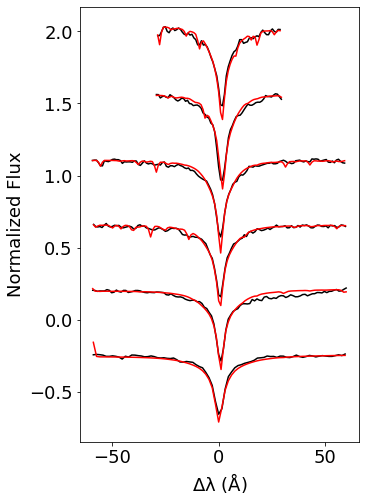

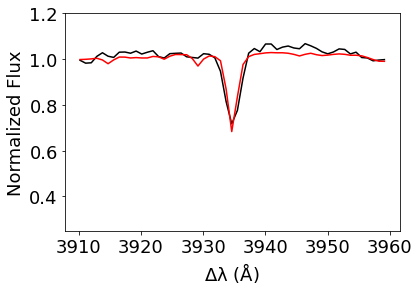

6560.910540622998 3.982510383175956 -2.82449529199883
15.515999999999998
sdA
----------------------------------------------------------------------------------------------------
2779958921396953088


<Figure size 720x216 with 0 Axes>

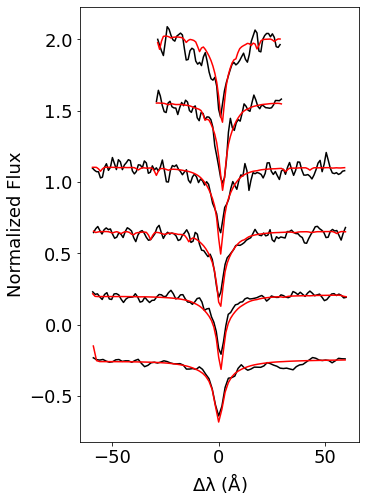

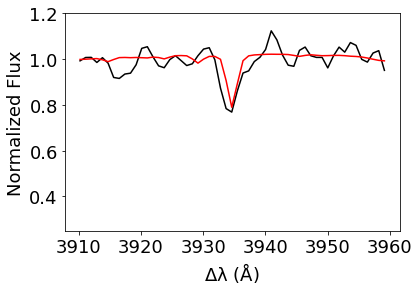

6415.87182961487 3.6481149669259505 -3.292471006898962
16.942999999999998
sdA/F
----------------------------------------------------------------------------------------------------
3092216989574463616


<Figure size 720x216 with 0 Axes>

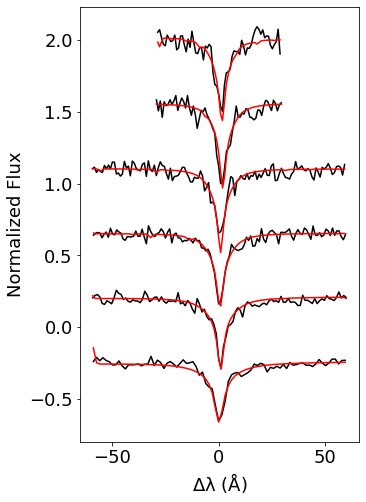

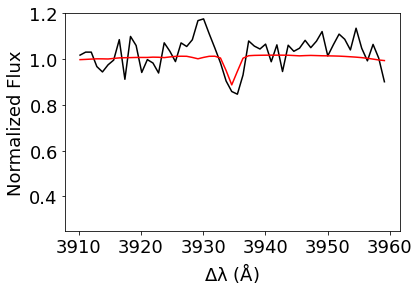

6441.131792188917 3.988291370842571 -3.937450093870825
17.061
sdA
----------------------------------------------------------------------------------------------------
1276882477044162688


<Figure size 720x216 with 0 Axes>

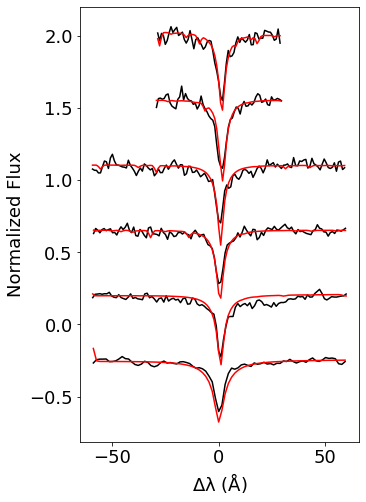

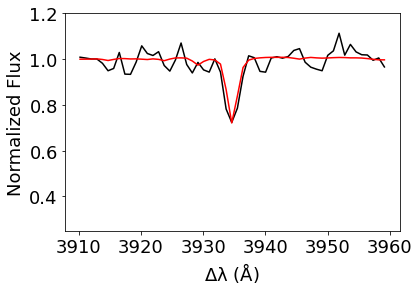

6333.462307146143 4.718212634443243 -3.403128244198016
16.581
sdA/F
----------------------------------------------------------------------------------------------------
1184737183522291712


<Figure size 720x216 with 0 Axes>

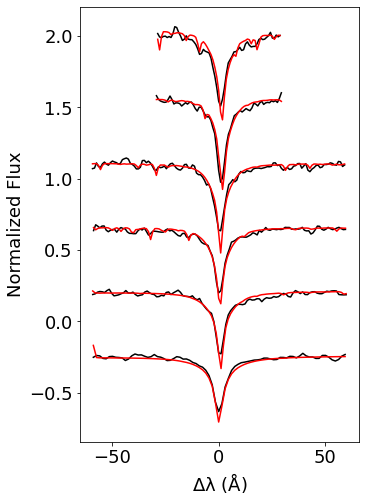

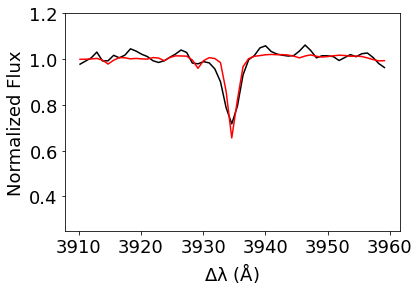

6445.383690949484 3.9999995701380833 -2.8744703575933745
16.16
sdA
----------------------------------------------------------------------------------------------------
3740963179636227968


<Figure size 720x216 with 0 Axes>

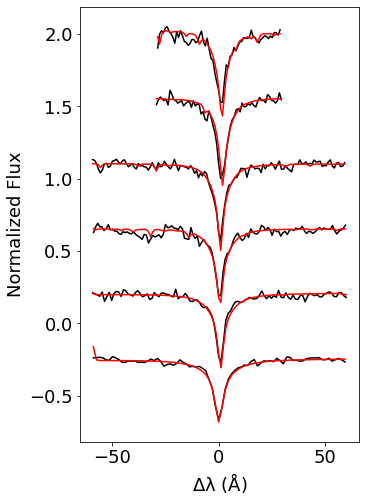

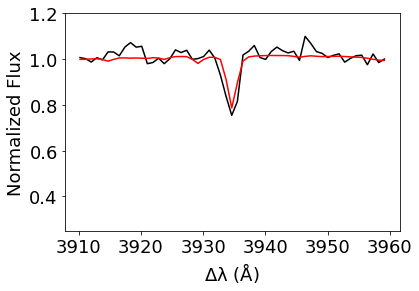

6340.320758568452 3.7740871570498573 -3.506032923550298
16.643
sdA
----------------------------------------------------------------------------------------------------
290930261314166528


<Figure size 720x216 with 0 Axes>

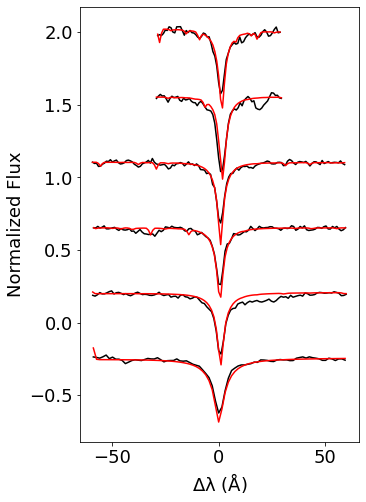

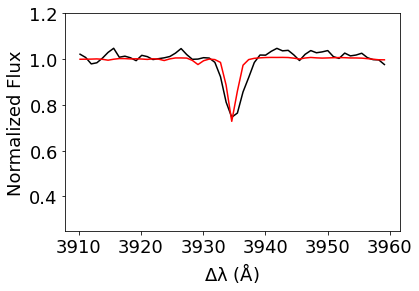

6353.5714570907985 4.8385450656099565 -3.535951079479194
15.82
sdA/F
----------------------------------------------------------------------------------------------------
4190837398756490112


<Figure size 720x216 with 0 Axes>

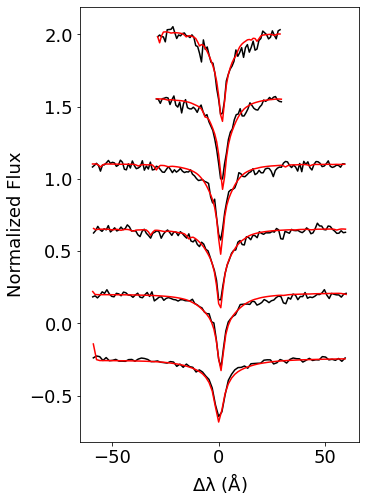

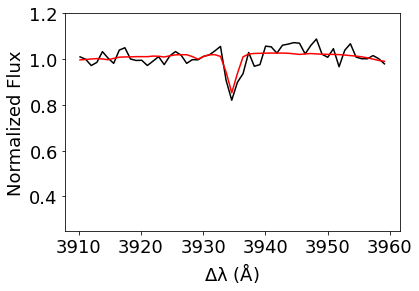

6536.341731973058 3.7914868084512996 -3.6421618425410682
16.967
sdA
----------------------------------------------------------------------------------------------------
3976087728282022272


<Figure size 720x216 with 0 Axes>

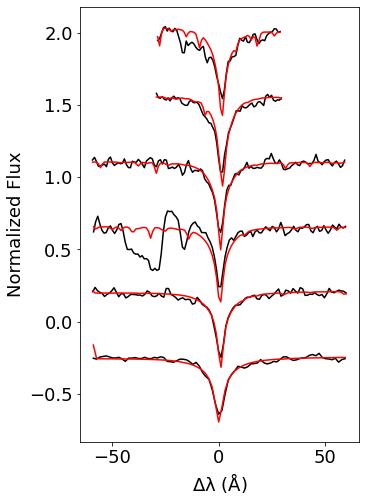

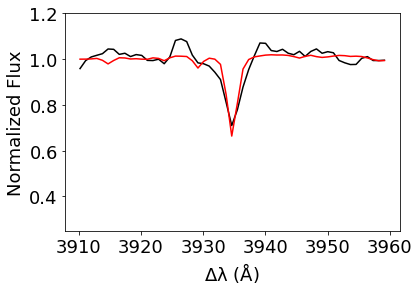

6425.685632323019 4.000000446741471 -2.8572298221597583
16.874000000000002
sdA/F
----------------------------------------------------------------------------------------------------
3890626773968983296


<Figure size 720x216 with 0 Axes>

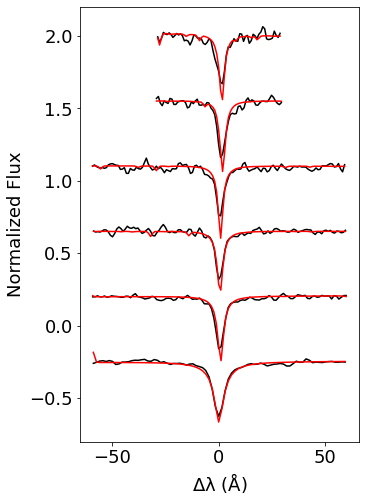

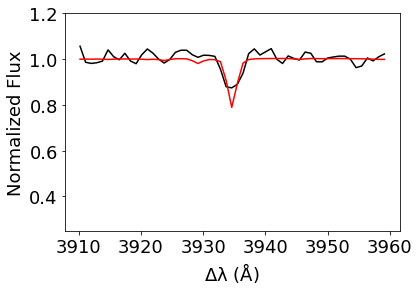

6046.530330175359 4.738756289883423 -3.9899999999836053
16.928
sdA


In [89]:
table['spec_teff'] = np.repeat(np.nan, len(table))
table['spec_logg'] = np.repeat(np.nan, len(table))
table['spec_feh'] = np.repeat(np.nan, len(table))
table['chisqr'] = np.repeat(np.nan, len(table))

table['mist_teff'] = np.repeat(np.nan, len(table))
table['mist_logg'] = np.repeat(np.nan, len(table))
table['mist_feh'] = np.repeat(np.nan, len(table))


teffs = []
loggs = []
fehs = []

for obj in table[knownselection]:
    path = '../../spec/%i_spec_0.fits' % obj['source_id']

    with fits.open(path) as f:
        fl = f[1].data['flux']
        wl = 10**f[1].data['loglam']
        sky = f[1].data['sky']

    wl,fl = rv_corr(wl, fl)
    
    try:
        print('--'*50)
        print(obj['source_id'])
        fit_params, mist_params, maz, chisqr = fit_star(wl, fl, sky, obj, make_plot = True)
        print(fit_params['teff'].value, fit_params['logg'].value, fit_params['feh'].value)
        print(obj['g'])
        print(obj['ty'])
        plt.show()
        teffs.append(fit_params['teff'].value)
        loggs.append(fit_params['logg'].value)
        fehs.append(fit_params['feh'].value)
    except:
        
        print('fit failed..')
        raise
        

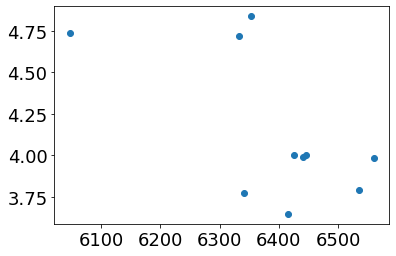

In [90]:
plt.scatter(teffs, loggs)

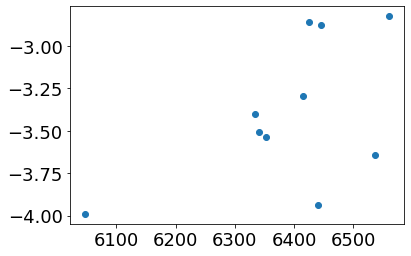

In [91]:
plt.scatter(teffs, fehs)

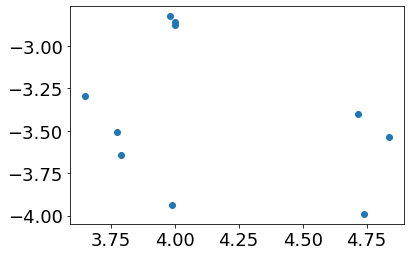

In [92]:
plt.scatter(loggs, fehs)

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.


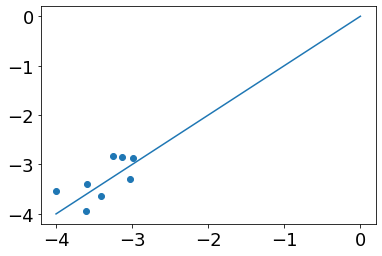

In [93]:
from astroquery.simbad import Simbad

Simbad.add_votable_fields('fe_h')

simfehs = [];
simteffs = [];
simloggs = [];

for obj in table[knownselection]:
    try:
        query = Simbad.query_object('Gaia DR2 %i' % obj['source_id'])
        simteff = query['Fe_H_Teff'][0]
        simlogg = query['Fe_H_log_g'][0]
        simfeh = query['Fe_H_Fe_H'][0]
    except:
        raise
        simteff = np.nan
        simlogg = np.nan
        simfeh = np.nan
        print('bluh')
    simfehs.append(simfeh)
    simloggs.append(simlogg)
    simteffs.append(simteff)
simfehs = np.array(simfehs)

plt.scatter(simfehs, fehs)

plt.plot([-4, 0], [-4, 0])

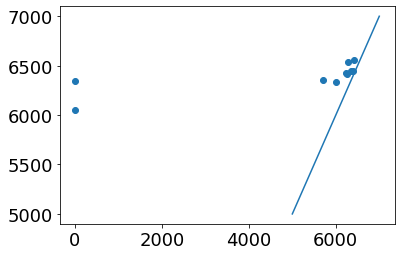

In [94]:
plt.scatter(simteffs, teffs)
plt.plot([5000, 7000], [5000, 7000])

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


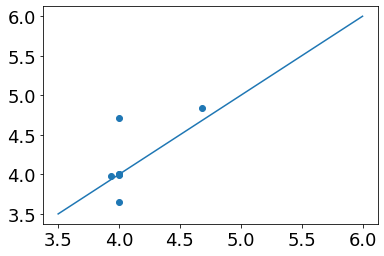

In [95]:
plt.scatter(simloggs, loggs)
plt.plot([3.5, 6], [3.5, 6])

In [96]:
Simbad.query_object('Gaia DR2 %i' % obj['source_id'])

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,Fe_H_Teff_1,Fe_H_log_g_1,Fe_H_Fe_H_1,Fe_H_flag_1,Fe_H_CompStar_1,Fe_H_CatNo_1,Fe_H_bibcode_1,Fe_H_Teff_2,Fe_H_log_g_2,Fe_H_Fe_H_2,Fe_H_flag_2,Fe_H_CompStar_2,Fe_H_CatNo_2,Fe_H_bibcode_2,Fe_H_Teff_3,Fe_H_log_g_3,Fe_H_Fe_H_3,Fe_H_flag_3,Fe_H_CompStar_3,Fe_H_CatNo_3,Fe_H_bibcode_3,Fe_H_Teff_4,Fe_H_log_g_4,Fe_H_Fe_H_4,Fe_H_flag_4,Fe_H_CompStar_4,Fe_H_CatNo_4,Fe_H_bibcode_4,Fe_H_Teff_5,Fe_H_log_g_5,Fe_H_Fe_H_5,Fe_H_flag_5,Fe_H_CompStar_5,Fe_H_CatNo_5,Fe_H_bibcode_5,Fe_H_Teff_6,Fe_H_log_g_6,Fe_H_Fe_H_6,Fe_H_flag_6,Fe_H_CompStar_6,Fe_H_CatNo_6,Fe_H_bibcode_6
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,,unit-degK,cm/s**2,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19,int32,float32,float32,str1,object,str5,str19
UCAC3 215-112497,10 29 15.1491,+17 29 27.926,14,14,0.083,0.062,90,A,O,2018yCat.1345....0G,0,--,--,,,,,0,--,--,,,,,0,--,--,,,,,0,--,--,,,,,0,--,--,,,,,0,--,--,,,,,0,--,--,,,,


## Fit all stars

In [97]:
selids = [3724067121891339648,
 874891332185786752,
4465215302785008640,
1448863790892447744,
3958825597588943232,
3905214200892445184,
1493736818927192576,
3092216989574463616,
 290930261314166528,
1276882477044162688,
4190837398756490112,
1184737183522291712,
3740963179636227968,
3976087728282022272,
3890626773968983296,
1609914447333432192,
1195572458297534080,
 931227322991970560,
2548541852945056896]

In [98]:
sel = np.array([obj['source_id'] in selids for obj in table])

In [106]:
table['spec_teff'] = np.repeat(np.nan, len(table))
table['spec_logg'] = np.repeat(np.nan, len(table))
table['spec_feh'] = np.repeat(np.nan, len(table))
table['chisqr'] = np.repeat(np.nan, len(table))

table['mist_teff'] = np.repeat(np.nan, len(table))
table['mist_logg'] = np.repeat(np.nan, len(table))
table['mist_feh'] = np.repeat(np.nan, len(table))

table['mist_mass'] = np.repeat(np.nan, len(table))
table['mist_age'] = np.repeat(np.nan, len(table))
table['post_plx'] = np.repeat(np.nan, len(table))

ii = 0
for obj in tqdm(table):
    
#     if obj['source_id'] not in selids:
#         continue
    
    path = '../../spec/%i_spec_0.fits' % obj['source_id']
    
    with fits.open(path) as f:
        fl = f[1].data['flux']
        wl = 10**f[1].data['loglam']
        sky = f[1].data['sky']

    wl,fl = rv_corr(wl, fl)
    try:
        fit_params, mist_params, maz, chisqr = fit_star(wl, fl, sky, obj, make_plot = False)
    except KeyboardInterrupt:
        break
    except:
        print('fit failed..')
        pass

    obj['spec_teff'] = fit_params['teff'].value
    obj['spec_logg'] = fit_params['logg'].value
    obj['spec_feh'] = fit_params['feh'].value
    
    obj['mist_teff'] = mist_params[0]
    obj['mist_logg'] = mist_params[1]
    obj['mist_feh'] = mist_params[2]
    
    obj['mist_mass'] = maz[0]
    obj['mist_age'] = maz[1]
    obj['post_plx'] = maz[-1]
    
    obj['chisqr'] = chisqr
    
    ii += 1
    
    if ii % 500 == 0:
        table.write('tables/jan28.fits', overwrite = True)

  1%|          | 86/10500 [03:16<6:24:15,  2.21s/it]/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


sky fit failed. defaulting to 1.5


  3%|▎         | 292/10500 [11:35<6:27:21,  2.28s/it]

sky fit failed. defaulting to 1.5


  5%|▍         | 497/10500 [19:50<5:20:17,  1.92s/it]

fit failed..


  5%|▍         | 503/10500 [20:05<6:41:39,  2.41s/it]

sky fit failed. defaulting to 1.5


 13%|█▎        | 1353/10500 [55:09<8:07:17,  3.20s/it]

sky fit failed. defaulting to 1.5


 13%|█▎        | 1403/10500 [57:26<6:38:25,  2.63s/it]

sky fit failed. defaulting to 1.5


 16%|█▌        | 1628/10500 [1:06:38<5:34:06,  2.26s/it]

sky fit failed. defaulting to 1.5


 22%|██▏       | 2355/10500 [1:34:28<4:23:16,  1.94s/it]

fit failed..


 23%|██▎       | 2384/10500 [1:35:33<4:24:16,  1.95s/it]

fit failed..


 35%|███▍      | 3665/10500 [2:24:04<3:38:38,  1.92s/it]

fit failed..


 39%|███▉      | 4083/10500 [2:40:03<3:49:31,  2.15s/it]

fit failed..


 40%|████      | 4202/10500 [2:44:25<4:03:04,  2.32s/it]

sky fit failed. defaulting to 1.5


 45%|████▍     | 4715/10500 [6:43:39<15:26:21,  9.61s/it]    

sky fit failed. defaulting to 1.5


 48%|████▊     | 5007/10500 [6:55:01<3:51:48,  2.53s/it] /Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  r

caution, none of the iterated fits were succesful


 48%|████▊     | 5008/10500 [6:55:03<3:32:27,  2.32s/it]

fit failed..


 58%|█████▊    | 6087/10500 [7:35:46<2:46:13,  2.26s/it]

fit failed..


 66%|██████▋   | 6975/10500 [8:09:27<2:14:06,  2.28s/it]

fit failed..


 68%|██████▊   | 7148/10500 [8:16:19<2:06:02,  2.26s/it]

fit failed..


 70%|███████   | 7382/10500 [8:25:16<1:56:04,  2.23s/it]

fit failed..


 72%|███████▏  | 7571/10500 [8:32:36<1:39:26,  2.04s/it]

sky fit failed. defaulting to 1.5


 73%|███████▎  | 7671/10500 [8:36:19<1:43:41,  2.20s/it]

fit failed..


 74%|███████▍  | 7762/10500 [8:39:42<1:34:26,  2.07s/it]

sky fit failed. defaulting to 1.5


 74%|███████▍  | 7807/10500 [8:41:24<1:51:57,  2.49s/it]

sky fit failed. defaulting to 1.5


 74%|███████▍  | 7812/10500 [8:41:34<1:16:52,  1.72s/it]

fit failed..


 84%|████████▍ | 8830/10500 [9:21:16<1:10:38,  2.54s/it]

sky fit failed. defaulting to 1.5


100%|██████████| 10500/10500 [10:49:07<00:00,  3.71s/it] 


In [108]:
table.write('tables/jan28.fits', overwrite = True)

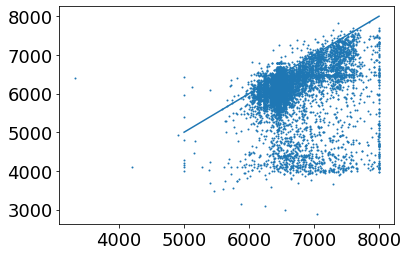

In [109]:
plt.scatter(table['spec_teff'], table['mist_teff'], s = 1)
plt.plot([5000, 8000], [5000, 8000])

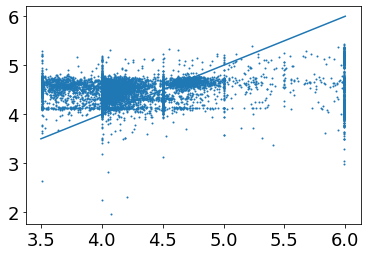

In [110]:
plt.scatter(table['spec_logg'], table['mist_logg'], s = 1)
plt.plot([3.5, 6], [3.5, 6])

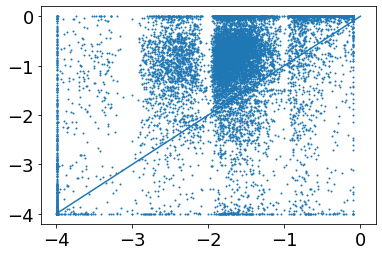

In [111]:
plt.scatter(table['spec_feh'], table['mist_feh'], s = 1)
plt.plot([-4, 0], [-4, 0])

(0.0, 1.0)

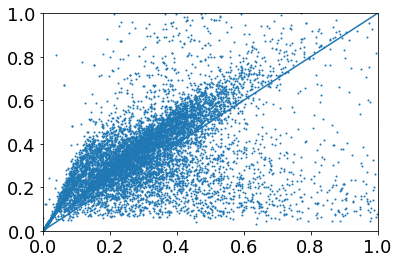

In [112]:
plt.scatter(table['parallax'], table['post_plx'], s = 1)
plt.plot([0, 2.5], [0, 2.5])

plt.xlim(0, 1)
plt.ylim(0, 1)

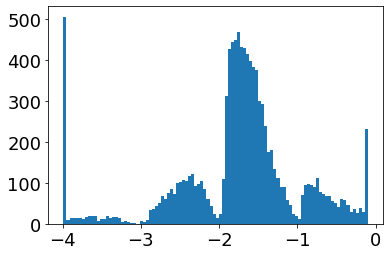

In [113]:
plt.hist(table['spec_feh'], bins = 100);

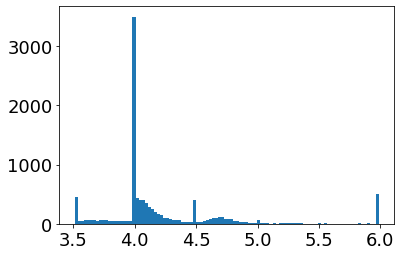

In [114]:
plt.hist(table['spec_logg'], bins = 100);

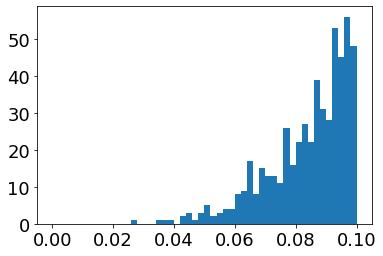

In [115]:
plt.hist(table['chisqr'], bins = 50, range = (0, 0.1));

In [116]:
np.nanmedian(table['chisqr'])

0.23872190778993324

In [117]:
np.nanquantile(table['chisqr'], 0.9)

1.590790987686502

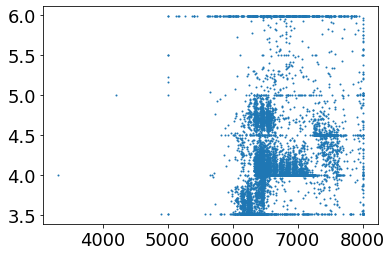

In [118]:
plt.scatter(table['spec_teff'], table['spec_logg'], s = 1)

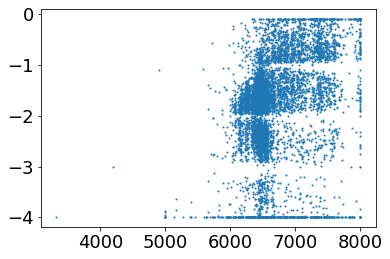

In [119]:
plt.scatter(table['spec_teff'], table['spec_feh'], s = 1)

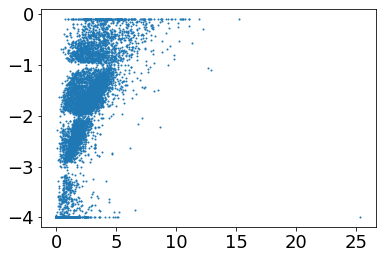

In [120]:
plt.scatter(table['ca2k'], table['spec_feh'], s = 1)

In [124]:
lowfeh = (
    (table['spec_feh']  < -3.5) * 
    (table['spec_feh'] >= -4) *
    (table['spec_teff'] < 8000) *
    (table['spec_logg'] > 3.75) * 
    (table['spec_logg'] < 5.75)*
    (table['g'] < 20)*
    (table['chisqr'] < 0.1)
)


print(np.sum(lowfeh))

known = [
3092216989574463616,
290930261314166528,
2779958921396953088,
1276882477044162688,
4190837398756490112,
2782111559005651584,
1184737183522291712,
3740963179636227968,
3976087728282022272,
3890626773968983296,
]

randidx = np.random.choice(table['source_id'], size = 100)

randomselection = np.array([sourceid in randidx for sourceid in table['source_id']])

knownselection = np.array([sourceid in known for sourceid in table['source_id']])

21


In [125]:
knownflag = [];
simfehs = [];

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 1684497825738399744
  (error.line, error.msg))


----------------------------------------------------------------------------------------------------
1684497825738399744


<Figure size 720x216 with 0 Axes>

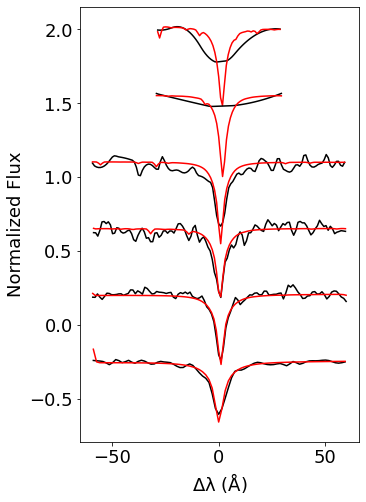

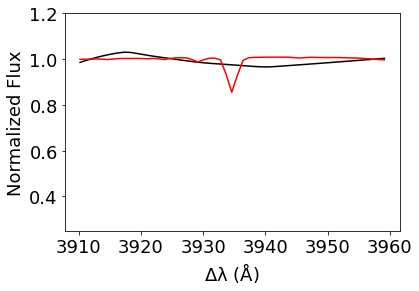

6135.159804725689 3.7575794821785347 -3.989999999953953
6135.159804725689 3.7575794821785347 -3.989999999953953
16.272000000000002
sdA/F
----------------------------------------------------------------------------------------------------
860153723141395712


<Figure size 720x216 with 0 Axes>

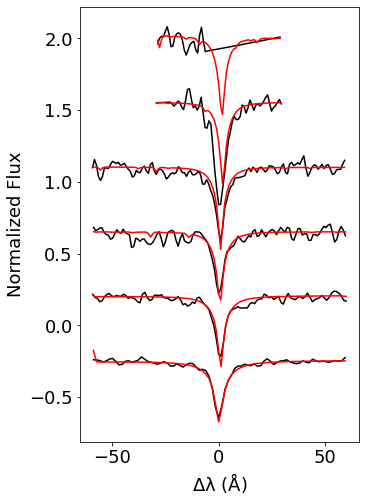

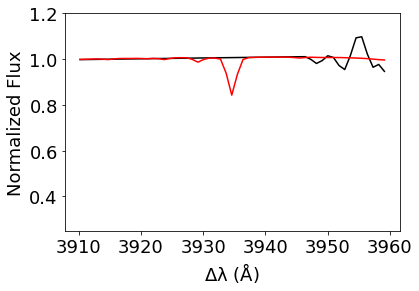

6162.906132276074 3.8336202877203225 -3.989999999809081
6162.906132276074 3.8336202877203225 -3.989999999809081
17.285999999999998
sdA/F


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 3717055364442598528
  (error.line, error.msg))


----------------------------------------------------------------------------------------------------
3717055364442598528


<Figure size 720x216 with 0 Axes>

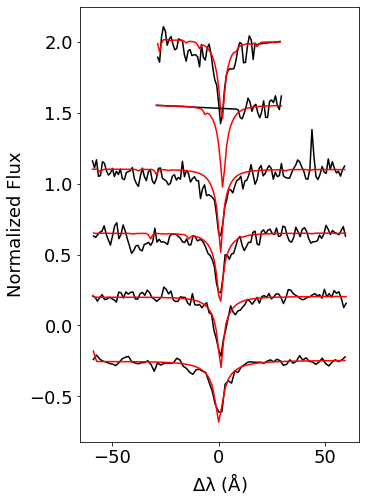

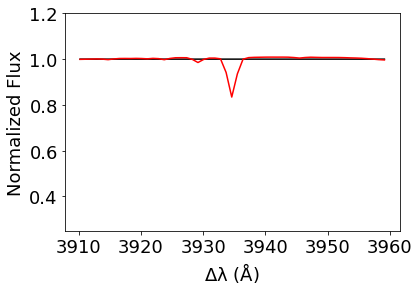

6149.957137452191 3.7852551284783926 -3.989999999824228
6149.957137452191 3.7852551284783926 -3.989999999824228
17.476
sdA/F


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 164453236908889984
  (error.line, error.msg))


----------------------------------------------------------------------------------------------------
164453236908889984


<Figure size 720x216 with 0 Axes>

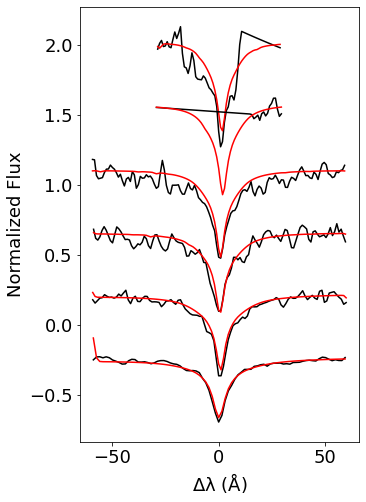

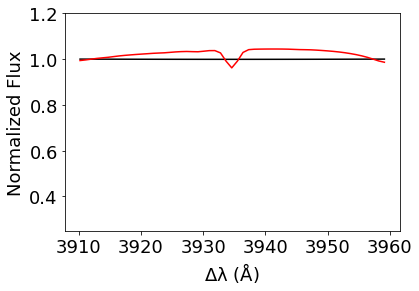

6873.674715402067 4.094382519265411 -3.9899999998040867
6873.674715402067 4.094382519265411 -3.9899999998040867
16.282
sdA
----------------------------------------------------------------------------------------------------
164453236908889984


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 164453236908889984
  (error.line, error.msg))


<Figure size 720x216 with 0 Axes>

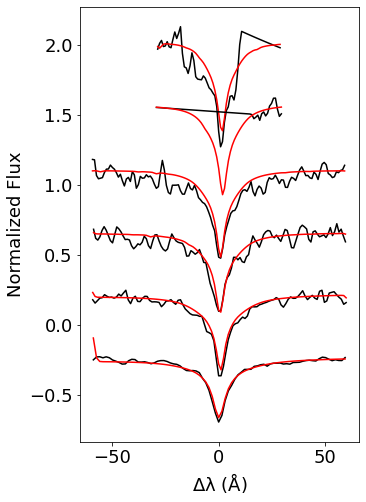

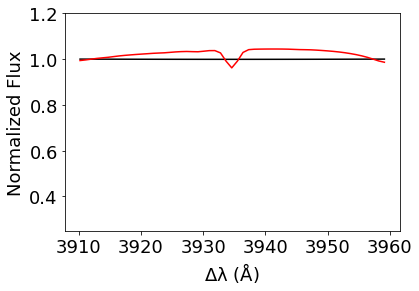

6873.674715402067 4.094382519265411 -3.9899999998040867
6873.674715402067 4.094382519265411 -3.9899999998040867
16.282
sdA
----------------------------------------------------------------------------------------------------
3740963179636227968


<Figure size 720x216 with 0 Axes>

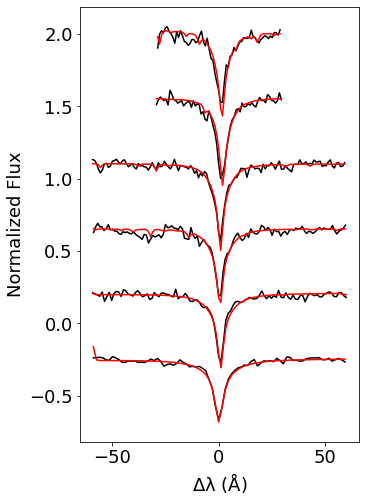

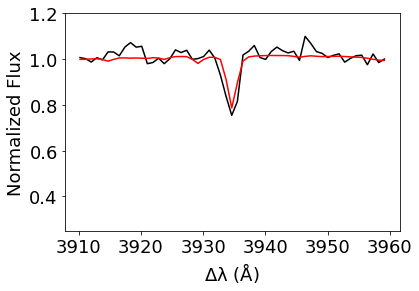

6340.320758568452 3.7740871570498573 -3.506032923550298
6340.320758568452 3.7740871570498573 -3.506032923550298
16.643
sdA


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 2690323705549527040
  (error.line, error.msg))


----------------------------------------------------------------------------------------------------
2690323705549527040


<Figure size 720x216 with 0 Axes>

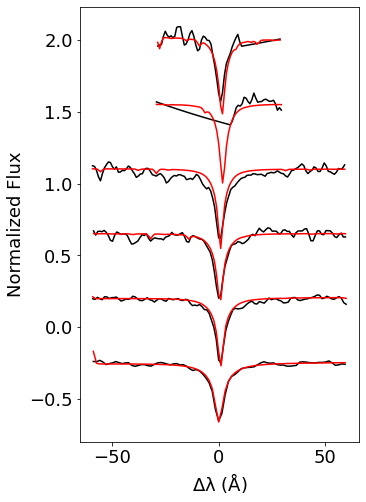

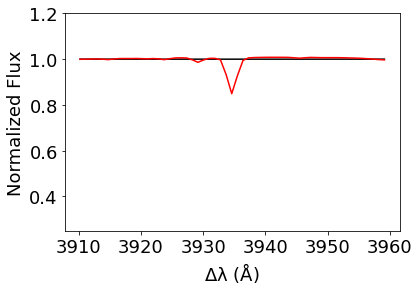

6118.331042950762 3.7784938234494323 -3.9899999998807476
6118.331042950762 3.7784938234494323 -3.9899999998807476
16.23
sdA/F
----------------------------------------------------------------------------------------------------
767103875148269696


<Figure size 720x216 with 0 Axes>

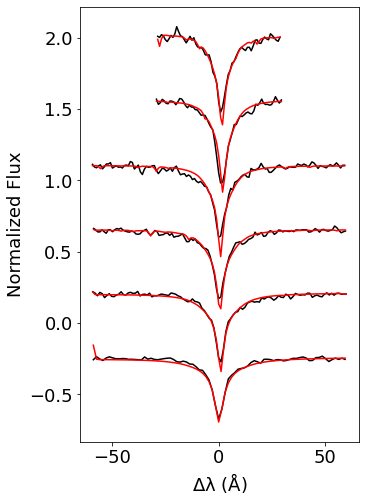

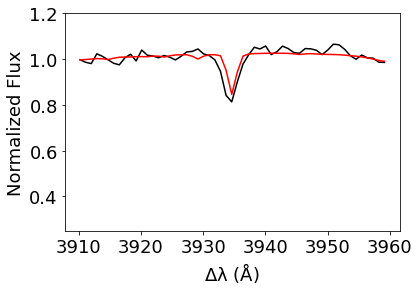

6551.334163343408 3.9286205720417238 -3.71163701183237
6551.334163343408 3.9286205720417238 -3.71163701183237
15.603
sdA
----------------------------------------------------------------------------------------------------
290930261314166528


<Figure size 720x216 with 0 Axes>

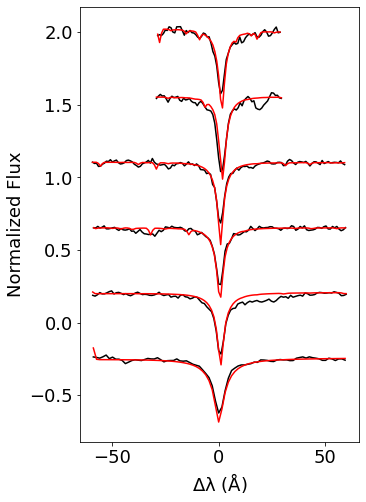

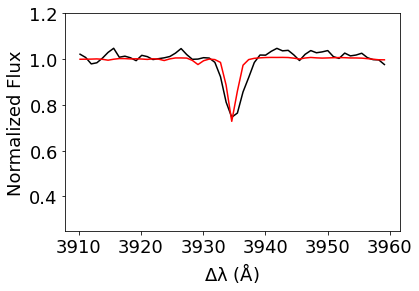

6353.5714570907985 4.8385450656099565 -3.535951079479194
6353.5714570907985 4.8385450656099565 -3.535951079479194
15.82
sdA/F
----------------------------------------------------------------------------------------------------
1448863790892447744


/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 1448863790892447744
  (error.line, error.msg))


<Figure size 720x216 with 0 Axes>

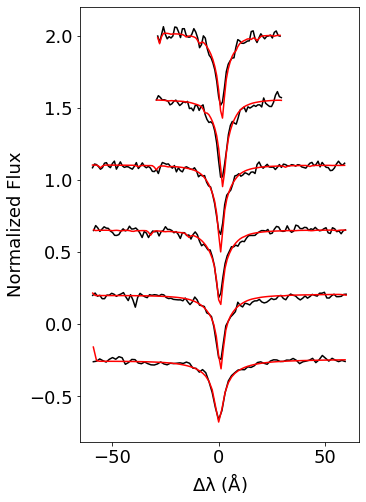

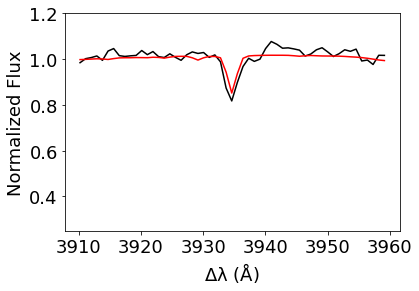

6434.678183188709 4.0000000078334175 -3.8316090630745094
6434.678183188709 4.0000000078334175 -3.8316090630745094
16.816
sdA
----------------------------------------------------------------------------------------------------
4190837398756490112


<Figure size 720x216 with 0 Axes>

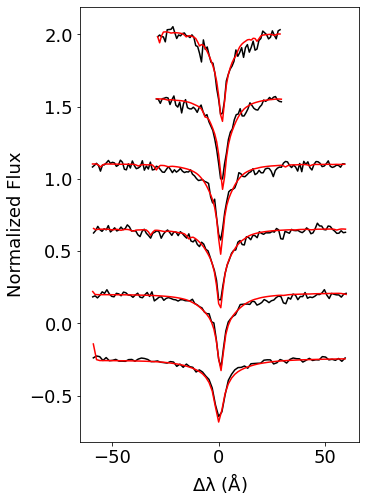

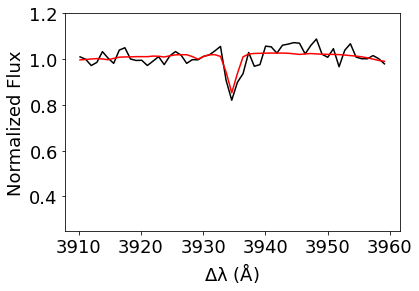

6536.341731973058 3.7914868084512996 -3.6421618425410682
6536.341731973058 3.7914868084512996 -3.6421618425410682
16.967
sdA


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))

In [126]:
for obj in table[lowfeh]:
    path = '../../spec/%i_spec_0.fits' % obj['source_id']

    with fits.open(path) as f:
        fl = f[1].data['flux']
        wl = 10**f[1].data['loglam']
        sky = f[1].data['sky']

    wl,fl = rv_corr(wl, fl)
    
    query = Simbad.query_object('Gaia DR2 %i' % obj['source_id'])
    if query is None:
        knownflag.append(0)
        simfehs.append(np.nan)
    else:
        knownflag.append(1)
        simfeh = query['Fe_H_Fe_H'][0]
        simfehs.append(simfeh)
    try:
        print('--'*50)
        print(obj['source_id'])
        fit_params, mist_params, _, chisqr = fit_star(wl, fl, sky, obj, make_plot = True)
        print(obj['spec_teff'], obj['spec_logg'], obj['spec_feh'])
        print(fit_params['teff'].value, fit_params['logg'].value, fit_params['feh'].value)
        print(obj['g'])
        print(obj['ty'])
        plt.show()
    except:
        print('fit failed..')
        raise

In [215]:
knownflag = np.array(knownflag)
simfehs = np.array(simfehs)

/Users/vedantchandra/opt/anaconda3/envs/wdtools/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Warning: converting a masked element to nan.
  


In [216]:
simfehs

array([        nan,         nan,         nan,         nan, -3.5999999 ,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.11000001,         nan,         nan,
               nan,         nan,         nan, -3.19000006,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan])

In [218]:
knownselection = table[lowfeh]['source_id'][knownflag == 1]
unknown = ~knownflag

In [226]:
plt.xkcd()

In [237]:
selection = [
3092216989574463616,
3724067121891339648,
874891332185786752,
4465215302785008640,
1448863790892447744,
1609914447333432192,
1195572458297534080,
3890626773968983296,
3187864781681367936,
3958825597588943232,
931227322991970560,
2548541852945056896,
3905214200892445184,
1493736818927192576,
    
]

known = [
3092216989574463616,
290930261314166528,
1276882477044162688,
4190837398756490112,
1184737183522291712,
3740963179636227968,
3976087728282022272,
3890626773968983296,
]